In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# For model training (classification)
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# For regression
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance


In [2]:
df = pd.read_json('data/full_pipe/data_features.json', lines= True)
df = df.sample(frac=1)  # To use all data, put frac = 1
df.columns

Index(['distance_mrt', 'town', 'area', 'flat_num', 'age_transation',
       'lease_commence', 'transaction_yr', 'transaction', 'storey_height',
       'resale_price', 'resale_price_adj', 'Postal', 'Location'],
      dtype='object')

In [3]:
# Data preprocessing to select out the relevant columns

columns = ['distance_mrt','age_transation','transaction_yr','Postal','storey_height', 'resale_price_adj','town','flat_num']

df_chosen = df[columns].copy()
df_chosen = df_chosen[df_chosen['Postal']!='NIL']  #remove the items with no postal code#
df_chosen['Postal'] = df_chosen['Postal'].astype(int)  #convert to int

print(df_chosen.shape[0], 'filtered out of:', df.shape[0])

162793 filtered out of: 162800


In [4]:
# Create train and test sets
model_data = df_chosen.copy()

X = model_data.drop('resale_price_adj', axis=1)
y = model_data['resale_price_adj']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=573)

In [5]:
X_train.head()

,distance_mrt,age_transation,transaction_yr,Postal,storey_height,town,flat_num
30598,0.343259,45,2018,150130,3,BUKIT MERAH,3 ROOM
88854,1.448885,28,2021,510203,1,PASIR RIS,EXECUTIVE
160194,0.597264,26,2023,730739,4,WOODLANDS,4 ROOM
90454,0.484514,8,2021,161056,3,BUKIT MERAH,5 ROOM
5799,0.563496,21,2017,730701,4,WOODLANDS,4 ROOM


In [6]:
# Create training/ testing pipelines
numeric_features = ['distance_mrt', 'age_transation',
       'transaction_yr', 'Postal',
       'storey_height']
categorical_features = ['town', 'flat_num']

numeric_transformer = StandardScaler()
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown = "ignore", sparse_output = False)
)

preprocess = make_column_transformer(
    (numeric_transformer, numeric_features),  
    (categorical_transformer, categorical_features)
)

In [7]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    print(out_col)
    return pd.Series(data=out_col, index=mean_scores.index)

In [9]:
# We will evaluate a set of models for this project
regressor_models = {
    "Dummy Regressor": DummyRegressor(), 
    "KNN Regressor": KNeighborsRegressor(),
    "Ridge": Ridge(random_state=1),
    "RFR": RandomForestRegressor(random_state=1, n_estimators=10), 
    "GB": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

cv_results_reg = {}
scoring_metrics = ['r2', 'neg_mean_absolute_error']

for model_name, model in regressor_models.items():
    pipe = make_pipeline(preprocess, model)
    cv_results_reg[model_name] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score=True, n_jobs=-1, scoring=scoring_metrics)
    print("Done with", model_name)

results_df_reg = pd.DataFrame(cv_results_reg).T
results_df_reg

['0.056 (+/- 0.005)', '0.011 (+/- 0.005)', '-0.000 (+/- 0.000)', '0.000 (+/- 0.000)', '-114211.247 (+/- 295.689)', '-114209.473 (+/- 47.021)']
Done with Dummy Regressor
['0.057 (+/- 0.002)', '8.074 (+/- 0.046)', '0.936 (+/- 0.002)', '0.959 (+/- 0.000)', '-25373.427 (+/- 167.999)', '-20341.029 (+/- 38.766)']
Done with KNN Regressor
['0.109 (+/- 0.011)', '0.018 (+/- 0.007)', '0.836 (+/- 0.002)', '0.836 (+/- 0.000)', '-44872.922 (+/- 236.557)', '-44855.094 (+/- 69.215)']
Done with Ridge
['5.775 (+/- 0.046)', '0.088 (+/- 0.010)', '0.961 (+/- 0.001)', '0.991 (+/- 0.000)', '-20582.371 (+/- 45.443)', '-9255.471 (+/- 29.847)']
Done with RFR
['15.022 (+/- 0.128)', '0.059 (+/- 0.016)', '0.887 (+/- 0.003)', '0.888 (+/- 0.001)', '-35238.860 (+/- 253.820)', '-35118.390 (+/- 83.500)']
Done with GB
['2.339 (+/- 0.141)', '0.053 (+/- 0.003)', '0.953 (+/- 0.001)', '0.958 (+/- 0.001)', '-22947.979 (+/- 40.430)', '-21835.571 (+/- 59.468)']
Done with XGBoost


,fit_time,score_time,test_r2,train_r2,test_neg_mean_absolute_error,train_neg_mean_absolute_error
Dummy Regressor,0.056 (+/- 0.005),0.011 (+/- 0.005),-0.000 (+/- 0.000),0.000 (+/- 0.000),-114211.247 (+/- 295.689),-114209.473 (+/- 47.021)
KNN Regressor,0.057 (+/- 0.002),8.074 (+/- 0.046),0.936 (+/- 0.002),0.959 (+/- 0.000),-25373.427 (+/- 167.999),-20341.029 (+/- 38.766)
Ridge,0.109 (+/- 0.011),0.018 (+/- 0.007),0.836 (+/- 0.002),0.836 (+/- 0.000),-44872.922 (+/- 236.557),-44855.094 (+/- 69.215)
RFR,5.775 (+/- 0.046),0.088 (+/- 0.010),0.961 (+/- 0.001),0.991 (+/- 0.000),-20582.371 (+/- 45.443),-9255.471 (+/- 29.847)
GB,15.022 (+/- 0.128),0.059 (+/- 0.016),0.887 (+/- 0.003),0.888 (+/- 0.001),-35238.860 (+/- 253.820),-35118.390 (+/- 83.500)
XGBoost,2.339 (+/- 0.141),0.053 (+/- 0.003),0.953 (+/- 0.001),0.958 (+/- 0.001),-22947.979 (+/- 40.430),-21835.571 (+/- 59.468)


In [10]:
# We will use XGBoost since it has the second highest test_r2 after randomforest. 
# However, the much smaller gap between test R2 and train R2 when compared to randomforest suggests that this model is less prone to overfitting. 

In [12]:
# Optimize the hyperparameters
pipe_xgb = make_pipeline(
    preprocess,
    xgb.XGBRegressor()
)

param_grid  = {
    'xgbregressor__gamma': [0,1,10,20,100],
    'xgbregressor__max_depth': [3,4,5,6,7]
}
xgb_random_search = RandomizedSearchCV(pipe_xgb, param_distributions=param_grid, n_iter=10, n_jobs=-1, return_train_score=True)
xgb_random_search.fit(X_train, y_train)


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['distance_mrt',
                                                                                'age_transation',
                                                                                'transaction_yr',
                                                                                'Postal',
                                                                                'storey_height']),
                                                                              ('pipeline',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['town',
                                                                                'flat_num'])])),
                                             ('xgbregr...
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]),
                   n_jobs=-1,
                   param_distributions={'xgbregressor__gamma': [0, 1, 10, 20,
                                                                100],
                                        'xgbregressor__max_depth': [3, 4, 5, 6,
                                                                    7]},
                   return_train_score=True)

In [16]:
results = pd.DataFrame(xgb_random_search.cv_results_)[
    [
        "mean_test_score",
        "param_xgbregressor__gamma", 
        "param_xgbregressor__max_depth",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

results

rank_test_score,1,1,3,3,5,5,7,7,9,9
mean_test_score,0.95767,0.95767,0.952892,0.952892,0.944915,0.944915,0.933797,0.933797,0.916853,0.916853
param_xgbregressor__gamma,1,0,1,20,1,100,0,10,1,0
param_xgbregressor__max_depth,7,7,6,6,5,5,4,4,3,3
mean_fit_time,3.980632,2.358294,2.223972,1.675085,1.5905,1.028057,2.699012,1.538935,1.93615,1.115566


In [19]:
opt_params = xgb_random_search.best_params_

In [22]:
pipe_xgb_opt = make_pipeline(
    preprocess,
    xgb.XGBRegressor(max_depth=opt_params['xgbregressor__max_depth'], gamma=opt_params['xgbregressor__gamma'])
)
pipe_xgb_opt.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['distance_mrt',
                                                   'age_transation',
                                                   'transaction_yr', 'Postal',
                                                   'storey_height']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['town', 'flat_num'])])),
                ('xgbregressor',
                 XGBRegressor(base_scor...
                              feature_types=None, gamma=1, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

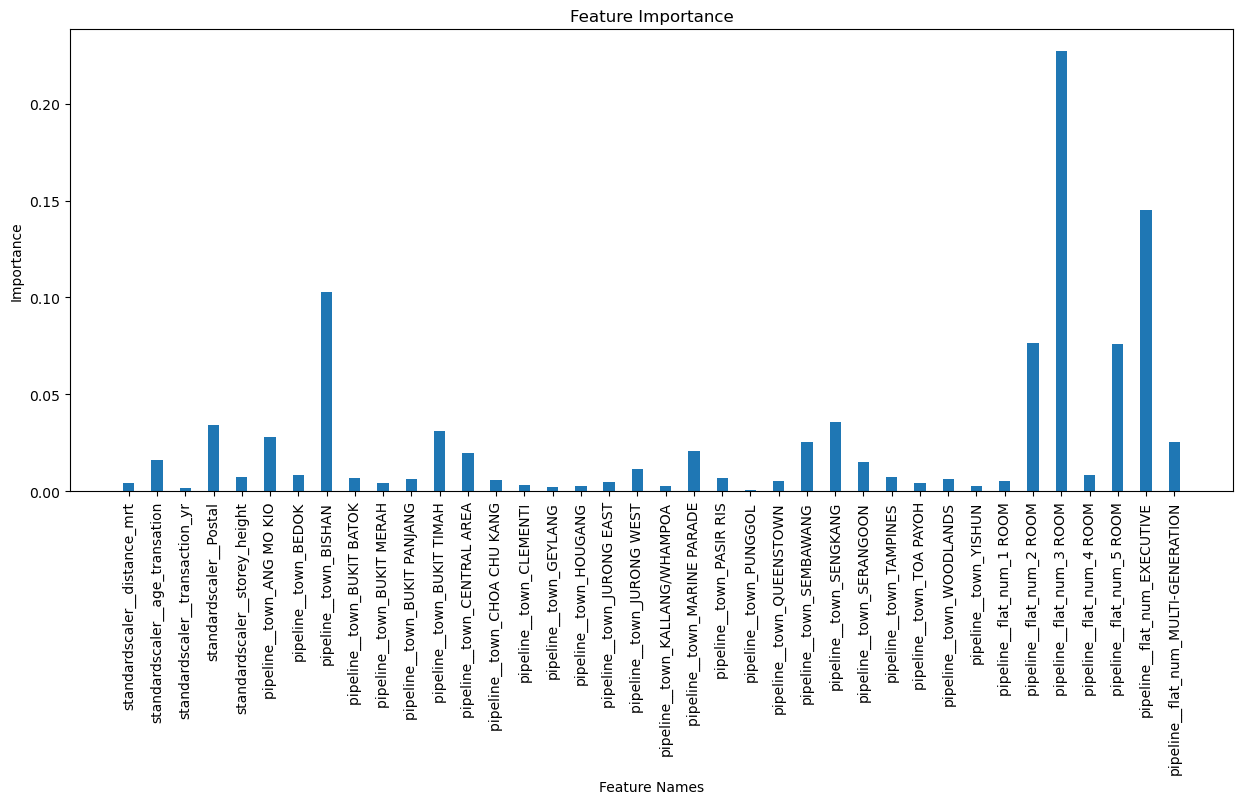

In [44]:
# Feature Importance

model = pipe_xgb_opt.named_steps['xgbregressor']
col_names = pipe_xgb_opt[:-1].get_feature_names_out()
feat_importance = model.feature_importances_

plt.figure(figsize=(15, 6))
x = range(len(col_names))
plt.bar(col_names, feat_importance, width=0.4, align='center', label='Feature Importance')
plt.xlabel('Feature Names')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(x, col_names, rotation=90)
plt.show()

In [46]:
pipe_xgb_opt.score(X_test, y_test)

0.958914794910254

In [48]:
# save the xgb model to disk
import pickle
filename = 'model/finalized_model.sav'
pickle.dump(pipe_xgb_opt, open(filename, 'wb'))

In [81]:
# To test if this saved model works

import pickle
import os

filename = 'model/finalized_model.sav'

# saving/loading data
if os.path.exists("./model/finalized_model.sav"):
    model = pickle.load(open(filename, 'rb'))
    print('loaded model')
else:
    pickle.dump(model, open(filename, 'wb'))

loaded model


In [55]:
#extract feature names#
feature_names = model[:-1].get_feature_names_out()
model.score(X_test, y_test)

0.958914794910254

In [79]:
model.predict(X_test.iloc[[622]])

array([245495.53], dtype=float32)

In [80]:
y_test.iloc[622]

256092.8961748634